<a href="https://colab.research.google.com/github/Jdean4747/Data5600HW/blob/main/CART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

In [99]:
df = pd.read_csv('/content/lendingclub.csv')

In [100]:
df.head()

,home_ownership,income,dti,fico,loan_status
0,1,43.0,39.66,670,0
1,1,80.0,39.54,685,1
2,0,30.0,39.52,695,1
3,1,105.0,39.45,710,0
4,0,28.6,39.28,680,1


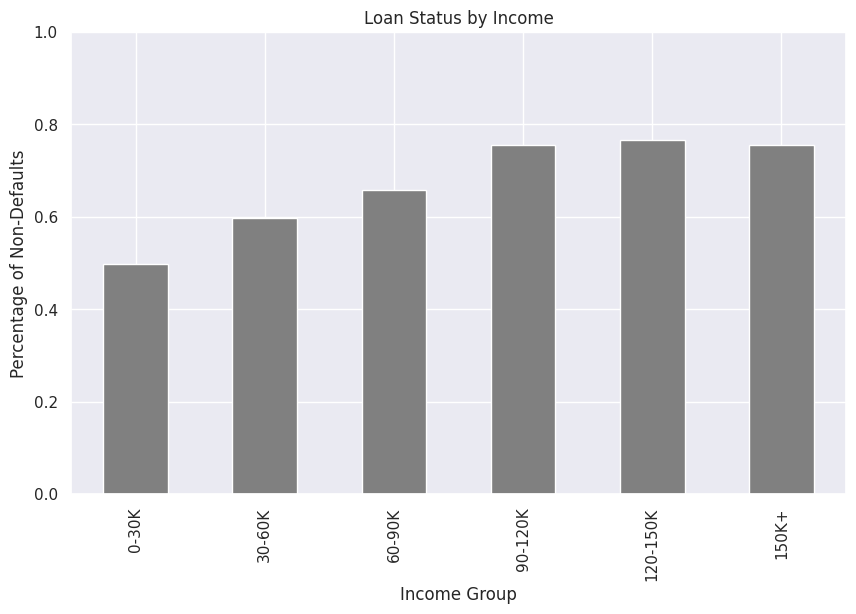

In [101]:
df['income_bins'] = pd.cut(df['income'], bins=[0, 30, 60, 90, 120, 150, 500], labels=['0-30K', '30-60K', '60-90K', '90-120K', '120-150K', '150K+'])
income_grouped = df.groupby('income_bins')['loan_status'].mean()
plt.figure(figsize=(10, 6))
income_grouped.plot(kind='bar', color=['grey'])
plt.title('Loan Status by Income')
plt.xlabel('Income Group')
plt.ylabel('Percentage of Non-Defaults')
plt.ylim(0, 1)
plt.show()


This bar graph shows that lower income people tend to have a worse record of repaying their loans. This can help banks to change policies so that there are more strict rules when loaning to people with lower income.

Proportion of Good Condition Loans (1) vs Defaulted (0):
loan_status
1    0.649339
0    0.350661
Name: proportion, dtype: float64


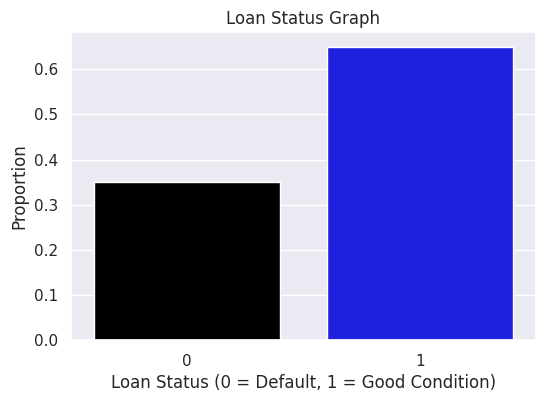

In [102]:
loan_counts = df['loan_status'].value_counts(normalize=True)
print("Proportion of Good Condition Loans (1) vs Defaulted (0):")
print(loan_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=loan_counts.index, y=loan_counts.values, palette=['black', 'blue'])
plt.title("Loan Status Graph")
plt.xlabel("Loan Status (0 = Default, 1 = Good Condition)")
plt.ylabel("Proportion")
plt.show()

This target variable is relatively slightly imbalanced because of the 65-35 balance.

In [103]:
X = df[['income', 'fico', 'dti', 'home_ownership']]
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_hat = dt.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.54      0.51       157
           1       0.74      0.70      0.72       297

    accuracy                           0.65       454
   macro avg       0.61      0.62      0.62       454
weighted avg       0.65      0.65      0.65       454



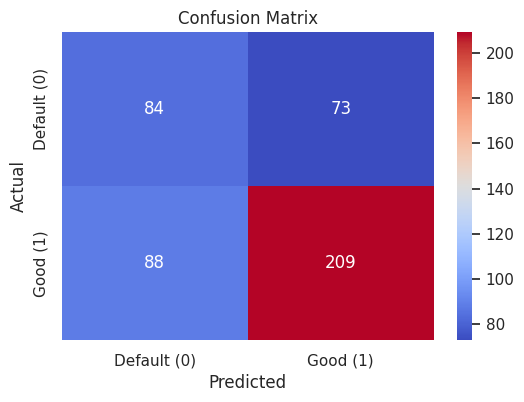

In [105]:
print("Classification Report:\n", classification_report(y_test, y_hat))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, fmt="d", cmap="coolwarm", xticklabels=['Default (0)', 'Good (1)'], yticklabels=['Default (0)', 'Good (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix shows us that the model predicts Good (1) too often which could predict a person who shouldn't get a loan to get one. The accuracy is 65 percent so the model predicts that percent correctly. For defaulted loans, the precision is 0.49 which means when the model predicts default then it is correct 49 percent of the time. The model is correct 54 percent of the time with the actual defaults. The 51 percent f1 score shows that this model is weak at predicting defaults. For good loans, the precision is 0.74 which means when the model predicts a good loan then it is correct 74 percent of the time. The model is correct 70 percent of the time with the actual good loans. The 72 percent f1 score shows that this model is strong at predicting good loans. I do not trust the accuracy of the model because it is not good at identifying the defaults.

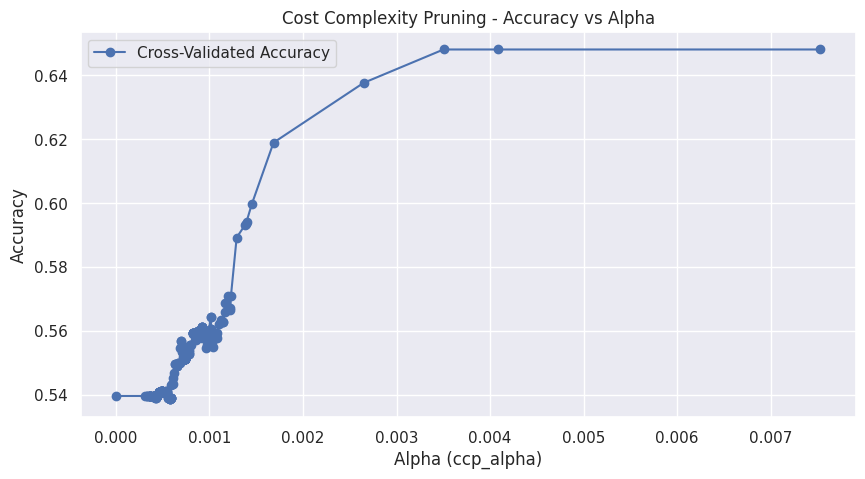

Optimal Alpha: 0.0035025262788646733


In [106]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

train_scores = []
test_scores = []

for alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    dt.fit(X_train, y_train)
    scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
    train_scores.append(np.mean(scores))

plt.figure(figsize=(10, 5))
plt.plot(ccp_alphas, train_scores, marker='o', label='Cross-Validated Accuracy')
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Accuracy")
plt.title("Cost Complexity Pruning - Accuracy vs Alpha")
plt.legend()
plt.show()

optimal_alpha = ccp_alphas[np.argmax(train_scores)]
print(f"Optimal Alpha: {optimal_alpha}")

In [107]:
dt_optimized = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_alpha)
dt_optimized.fit(X_train, y_train)

y_hat_optimized = dt_optimized.predict(X_test)

In [108]:
print("Original Model Metrics:")
print(classification_report(y_test, y_hat))
print("Optimized Model Metrics:")
print(classification_report(y_test, y_hat_optimized))
cm_optimized = confusion_matrix(y_test, y_hat_optimized)
print("Optimized Confusion Matrix:\n", cm_optimized)

Original Model Metrics:
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       157
           1       0.74      0.70      0.72       297

    accuracy                           0.65       454
   macro avg       0.61      0.62      0.62       454
weighted avg       0.65      0.65      0.65       454

Optimized Model Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       157
           1       0.65      1.00      0.79       297

    accuracy                           0.65       454
   macro avg       0.33      0.50      0.40       454
weighted avg       0.43      0.65      0.52       454

Optimized Confusion Matrix:
 [[  0 157]
 [  0 297]]


What I see happening is the default is totally being ignored so that the good loans can be more correct. All the scores for the default variable are 0 where as the good loans are higher.

In [109]:
cv_accuracy = cross_val_score(dt_optimized, X_test, y_test, cv=5, scoring="accuracy")
cv_accuracy.mean()

np.float64(0.5793650793650793)

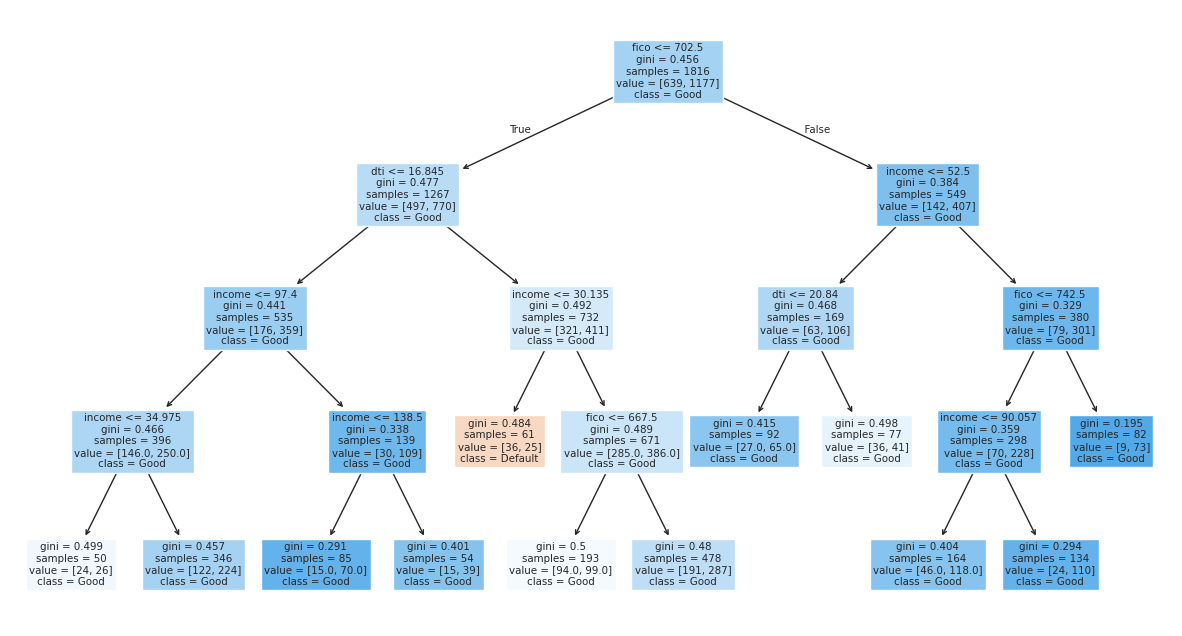

In [110]:
dt_viz = DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, random_state=42)
dt_viz.fit(X_train, y_train)

plt.figure(figsize=(15, 8))
plot_tree(dt_viz, feature_names=X_train.columns, class_names=["Default", "Good"], filled=True)
plt.show()

The FICO variable is the most important feature when deciding who to give a loan to with a cuttoff point of 702.5. I went less than 702.5 FICO, then less than 16.485 DTI, and then less than 30.135 income to finish with a denial of a loan. There are not a ton of terminal nodes because of pruning.